In [95]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)
user_base = pd.read_csv("../data/processed/user_base.csv")
user_history = pd.read_csv('../data/raw/user_history.csv')

print("Shape:", user_base.shape)
display(user_base.head())

Shape: (4979, 87)


,login_id,registration_date_id,registration_channel,registration_country,payer,dau,sessions_count,playtime,last_login_day,days_active_last_7_days,...,milestone_points,date_id,group,allowed_notifications,date_id_notif,notif_exposed,allowed,retained_d1,retained_d7,retained_d14
0,1,0,Organic,Canada,False,1,3,1351,0,1,...,0,0,group2_odd,NaN,NaN,False,0,False,False,False
1,2,0,Organic,Brazil,False,1,1,1046,0,1,...,0,0,group1_even,True,0.0,True,1,False,False,False
2,3,0,Organic,Brazil,False,1,7,5854,0,1,...,0,0,group2_odd,False,0.0,True,0,True,True,True
3,4,0,Paid,France,False,1,1,772,0,1,...,0,0,group1_even,False,0.0,True,0,False,False,False
4,5,0,Paid,United Kingdom,False,1,1,521,0,1,...,0,0,group2_odd,NaN,NaN,False,0,False,False,False


### Hocemo da predvidimo allowed (0/1) na osnovu early engagement feature-a

***Pitamo se, ko su useri koji dozvoljavaju notifikacije?***\
Ne smememo da koristimo
- date_id_notif (jer govori koliko je igrao pre popup-a)

Ali smemo:
- playtime, sessions, battles (jer opisuje ko je taj user)

In [96]:
#feature selection
features = [
    "playtime",
    "sessions_count",
    "battles_played",
    "elo_rating",
]

X = user_base[features]
y = user_base["allowed"]

print(X.describe())
print("\nTarget mean (allow rate):", y.mean())

           playtime  sessions_count  battles_played   elo_rating
count   4979.000000     4979.000000     4979.000000  4979.000000
mean    3281.611769        4.285800        7.158064    46.411729
std     4387.666041        4.608809        8.525087    91.930107
min        0.000000        0.000000        0.000000     0.000000
25%      861.000000        1.000000        2.000000     0.000000
50%     1708.000000        3.000000        4.000000    10.000000
75%     4003.500000        6.000000        9.000000    55.000000
max    70822.000000       62.000000      120.000000  1169.000000

Target mean (allow rate): 0.46093593090982127


In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (3734, 4)
Test size: (1245, 4)


## Logistic baseline

In [99]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)

print("ROC AUC:", auc)
print("\nClassification report:")
print(classification_report(y_test, y_pred))

ROC AUC: 0.713609361450225

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.83      0.73       671
           1       0.70      0.46      0.56       574

    accuracy                           0.66      1245
   macro avg       0.67      0.65      0.64      1245
weighted avg       0.67      0.66      0.65      1245



***SUPPORT***\
671 - nisu allow\
574 - jesu allow

***Model uci kakvi su korisnici koji su prihvatili notifikacije nakon prvog dana ponasanja.***\
***Za cist model bih smeo da koristim samo ono što je dostupno pre popup-a:***\
Za group1:
- samo registration info

Za group2:
- samo tutorial signal

U ovom datasetu takav timing ne postoji.

ROC AUC = 0.71 \
To znaci:
- model ume da razlikuje “will allow” vs “won’t allow” u ~71% slucajeva
- daleko bolje od slučajnog (0.50)
- dobro za jednostavne early behavior feature-e

`Recall = 0.46`
- model uhvati 46% svih koji ce dozvoliti

`Precision = 0.70`
- kad model kaze “ovaj ce dozvoliti”, cesto je u pravu

In [100]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": log_reg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
2,battles_played,1.459038
1,sessions_count,0.632239
0,playtime,-0.249265
3,elo_rating,-1.045688


In [101]:
## vise borbi -> veca sansa da dozvoli!
# playtime negativan zasto??
 # jako skewed
 # korelisan sa battles i sessions

# elo rating negativan zasto?
# multikolinearnost sa battles i playtime

## Random Forest

In [102]:
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=6,
    min_samples_leaf=30,
    random_state=42
)

rf.fit(X_train, y_train)

rf_proba = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

print("Random Forest AUC:", rf_auc)

Random Forest AUC: 0.7158292527144987


In [110]:
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": rf.feature_importances_
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
1,sessions_count,0.383373
0,playtime,0.360505
2,battles_played,0.217936
3,elo_rating,0.038186


### Pokusavamo da to malo poboljsamo

In [87]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [300, 600, 1000, 1500],
    "max_depth": [None, 4, 6, 8, 10, 14],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 5, 10, 20, 30, 50],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=40,                 
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)

print("Best CV AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_rf = search.best_estimator_
rf_proba = best_rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)
print("Test AUC:", rf_auc)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV AUC: 0.724077110856817
Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.3, 'max_depth': 4, 'class_weight': None, 'bootstrap': True}
Test AUC: 0.7160097000160974


In [103]:
# zasto je isto koa logistic regression?
 # nema mnogo kompleksnih nelinearnosti koje drvo moze da “otkrije”
 # model je stabilan, sto je odlicno za business

In [104]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)

gb_proba = gb.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test, gb_proba)

print("Gradient Boosting AUC:", gb_auc)

Gradient Boosting AUC: 0.7151593907891389


In [105]:
# Logistic Regression → 0.71
# Random Forest → 0.716
# Gradient Boosting → 0.715

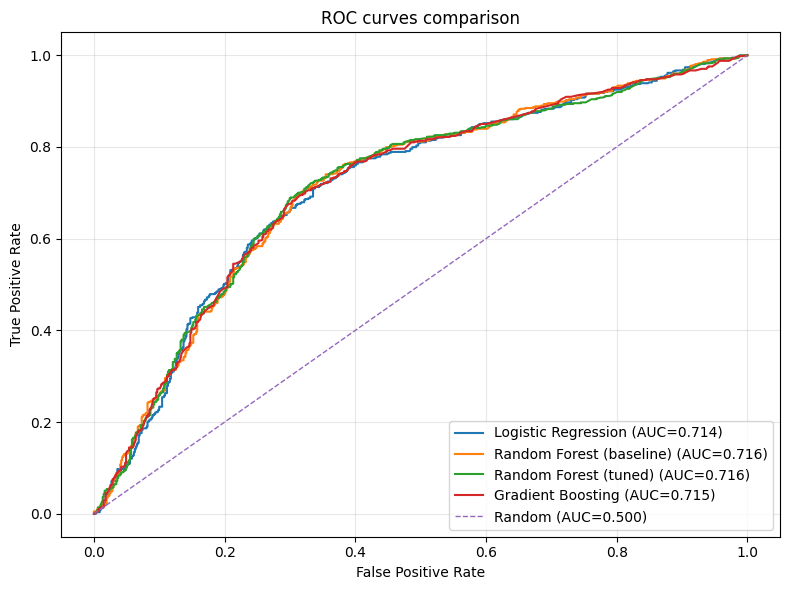

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

models = [
    ("Logistic Regression", log_reg, X_test_scaled),
    ("Random Forest (baseline)", rf, X_test),
    ("Random Forest (tuned)", best_rf, X_test),
    ("Gradient Boosting", gb, X_test),
]

plt.figure(figsize=(8, 6))

for name, model, X_te in models:
    y_score = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random (AUC=0.500)")

plt.title("ROC curves comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [111]:
# probacemo da koristimo vise atributa

In [112]:
numeric_cols = user_base.select_dtypes(include=[np.number]).columns.tolist()

drop_cols = ["login_id", "allowed"]

wide_features = [c for c in numeric_cols if c not in drop_cols]

print("Number of features:", len(wide_features))
wide_features[:20]

Number of features: 76


['registration_date_id',
 'dau',
 'sessions_count',
 'playtime',
 'last_login_day',
 'days_active_last_7_days',
 'cohort_size',
 'elo_rating',
 'arena_level',
 'gold',
 'runes_stash_class1_tier1',
 'runes_stash_class2_tier1',
 'runes_stash_class3_tier1',
 'runes_stash_tier2',
 'spell_runes_stash',
 'hero_dust',
 'item_dust',
 'gold_gained_total',
 'gold_bought_total',
 'gold_spent_total']

In [113]:
X_wide = user_base[wide_features]
y = user_base["allowed"]

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_wide, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

rf_wide = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_wide.fit(Xw_train, yw_train)

rf_wide_proba = rf_wide.predict_proba(Xw_test)[:, 1]
rf_wide_auc = roc_auc_score(yw_test, rf_wide_proba)

print("Wide feature Random Forest AUC:", rf_wide_auc)

Wide feature Random Forest AUC: 0.763118129371628


In [114]:
importances = pd.DataFrame({
    "feature": wide_features,
    "importance": rf_wide.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(5)

,feature,importance
75,date_id_notif,0.250700
3,playtime,0.060613
41,hero_shards,0.059426
17,gold_gained_total,0.050435
2,sessions_count,0.046587


| Feature set               | Model         | AUC       |
| ------------------------- | ------------- | --------- |
| Early engagement only     | Logistic / RF | ~0.71     |
| Full behavioral telemetry | Random Forest | **~0.76** |

`date_id_notif` predstavlja dan kada je popup prikazan, sto zavisi od buduceg ponasanja korisnika.
Kako je ova informacija nepoznata u trenutku predikcije i snazno povezana sa ishodom, ona uvodi
data leakage i vestacki povecava performanse modela.

date_id_notif je ***DATA LEAKAGE*** (i zato je #1 feature)

- date_id_notif → importance 0.25 

To znači:
- model koristi INFORMACIJU KOJA JE NASTALA NAKON popup-a

A to ne sme da se radi u predikciji.

***Uocavamo visoku vaznost vremena prikazivanja notifikacije, koje predstavlja informaciju nakon izlaganja i dovodi do data leakage-a. \
Nakon uklanjanja leakage feature-a, performanse modela realno odrazavaju pravi prediktivni signal.***


In [115]:
leakage_cols = [
    "date_id_notif",
    "date_id",
    "last_login_day"
]

clean_wide_features = [c for c in wide_features if c not in leakage_cols]

print("Features after leakage removal:", len(clean_wide_features))

X_clean = user_base[clean_wide_features]
y = user_base["allowed"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clean, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

rf_clean = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_clean.fit(Xc_train, yc_train)

clean_proba = rf_clean.predict_proba(Xc_test)[:, 1]
clean_auc = roc_auc_score(yc_test, clean_proba)

print("Clean wide model AUC (no leakage):", clean_auc)


Features after leakage removal: 73
Clean wide model AUC (no leakage): 0.7110052083062879


In [116]:
importances = pd.DataFrame({
    "feature": clean_wide_features,
    "importance": rf_clean.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(5)

,feature,importance
2,sessions_count,0.088437
40,hero_shards,0.072659
3,playtime,0.071375
16,gold_gained_total,0.068833
8,gold,0.060252


| Model               | Feature set                   | AUC        |
| ------------------- | ----------------------------- | ---------- |
| Logistic regression | early engagement              | **0.71**   |
| Random forest       | early engagement              | **0.716**  |
| Random forest       | rich telemetry (with leakage) | **0.76** ! |
| Random forest       | rich telemetry (clean)        | **0.71**   |

***Skok na 0.76 je bio lažan boost zbog data leakage-a***
- Kada uklonimo future info → model se vraća na ~0.71
- Early engagement već nosi skoro sav realan signal

### Probacemo jos jednom da uvedemo i samo 2 kategoricka atributa, da vidimo da li ce se nesto promeniti

In [117]:
user_base = pd.read_csv("../data/processed/user_base.csv")

numeric_features = [
    "playtime",
    "sessions_count",
    "battles_played",
    "elo_rating",
    "days_active_last_7_days"
]

categorical_features = [
    "registration_channel",  
    "payer"                   
]

X = user_base[numeric_features + categorical_features]
y = user_base["allowed"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)


model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(max_iter=1000))
    ]
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)

print("ROC AUC:", round(auc, 4))
print("\nClassification report:")
print(classification_report(y_test, y_pred))


ROC AUC: 0.7079

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       671
           1       0.68      0.47      0.56       574

    accuracy                           0.66      1245
   macro avg       0.66      0.64      0.64      1245
weighted avg       0.66      0.66      0.64      1245



***Nista se nije promenilo***

### Retention prediction based on early engagement

In [118]:
first_day = user_history[user_history["date_id"] == user_history["registration_date_id"]].copy()

first_day = (
    first_day.sort_values(["login_id", "date_id"])
            .drop_duplicates("login_id", keep="first")
)

first_day["group"] = np.where(first_day["login_id"] % 2 == 0, "group1_even", "group2_odd")

In [119]:
active_lookup = set(
    zip(
        user_history.loc[user_history["dau"] == 1, "login_id"],
        user_history.loc[user_history["dau"] == 1, "date_id"]
    )
)

def is_retained(row, horizon):
    target_day = int(row["registration_date_id"]) + int(horizon)
    return (int(row["login_id"]), target_day) in active_lookup

In [120]:
first_day["retained_d7"] = first_day.apply(lambda r: is_retained(r, 7), axis=1).astype(int)
first_day["retained_d14"] = first_day.apply(lambda r: is_retained(r, 14), axis=1).astype(int)

numeric_features = [
    "playtime",
    "sessions_count",
    "battles_played",
    "elo_rating",
]

categorical_features = [
    "registration_channel",
    "registration_country",
    "payer",
]

all_feats = numeric_features + categorical_features
X = first_day[all_feats].copy()

In [121]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), categorical_features),
    ]
)

clf = LogisticRegression(
    max_iter=4000,
    solver="lbfgs"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", clf)
])

In [122]:
for target in ["retained_d7", "retained_d14"]:
    y = first_day[target].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    pipe.fit(X_train, y_train)

    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, proba)

    print("\n" + "="*60)
    print(f"Target: {target} | Base rate: {y.mean():.3f} | ROC AUC: {auc:.4f}")
    print(classification_report(y_test, pred))


Target: retained_d7 | Base rate: 0.245 | ROC AUC: 0.9702
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       939
           1       0.88      0.78      0.82       306

    accuracy                           0.92      1245
   macro avg       0.90      0.87      0.89      1245
weighted avg       0.92      0.92      0.92      1245


Target: retained_d14 | Base rate: 0.183 | ROC AUC: 0.9638
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1018
           1       0.84      0.70      0.76       227

    accuracy                           0.92      1245
   macro avg       0.89      0.83      0.86      1245
weighted avg       0.92      0.92      0.92      1245



***SUPPORT***\
939 - churnovalo\
306 - ostalo aktivno

***PRECISION***
- kada ***model*** kaze OVAJ USER CE OSTATI AKTIVAN
    - u 88% slucajeva je u pravu
- kada model kaze ovaj user ce CHURN-ovati
    - u pravu je u 93% slucajeva
 
***RECALL***
- od svih usera koji su ZAISTA aktivni
    - model uspe da prepozna 78% njih
    - za 22% promakne, misli da ce churnovati
- od svih koji su ZAISTA churnovali
    - model uvhati 97% njih
 
***f1-score***
- visok kada su oba dobra

In [123]:
print("\n" + "="*60)
print("Sanity check (shuffle y):")
rng = np.random.RandomState(42)
y_shuffled = first_day["retained_d7"].values.copy()
rng.shuffle(y_shuffled)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_shuffled,
    test_size=0.25,
    random_state=42,
    stratify=y_shuffled
)

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:, 1]
auc_shuf = roc_auc_score(y_test, proba)
print(f"Shuffled retained_d7 AUC: {auc_shuf:.4f}")


Sanity check (shuffle y):
Shuffled retained_d7 AUC: 0.5023


***Retention model baziran na prvom danu ponasanja korisnika pruza realnu i primenljivu predikciju dugorocnog zadrzavanja, bez koriscenja buducih informacija***